This notebook attempts to extract images of single seeds from the raw video data.

Requirements:

```sh
pip install matplotlib opencv-python numpy
```

In [2]:
import cv2
import skimage

In [3]:
vidcap = cv2.VideoCapture('raw/kaura_1.avi', None)

nth_frame = 30
frames = []
frame_counter = 0

while True:
    success, image = vidcap.read()
    if not success: break

    frame_counter += 1
    if frame_counter == nth_frame:
        frame_counter = 0
        frames.append(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

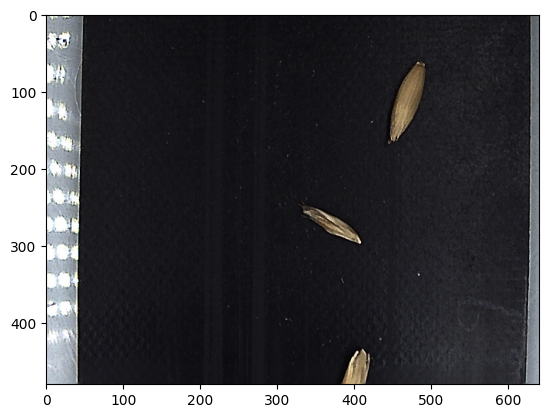

In [4]:
import matplotlib.pyplot as plt
import random

plt.imshow(frames[80])

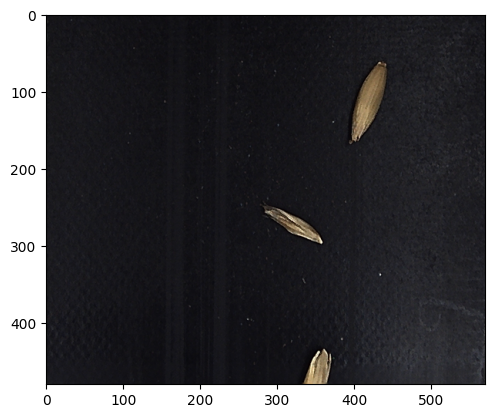

In [5]:
# Crop the image to get rid of the left and right edges

cropped_frames = [frame[:, 50:620] for frame in frames]

plt.imshow(cropped_frames[80])

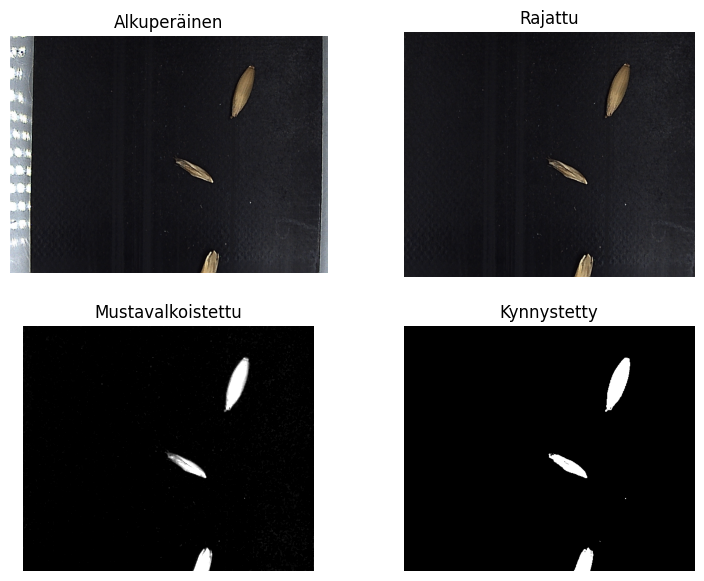

In [63]:
# Threshold the image

SEED_THRESHOLD = 75 / 255

def rgb2gray(image):
    image = image / 255
    return image[:,:,0] * 4 + image[:,:,1] * 1 + image[:,:,2] * -4.5

grayscale_frames = [rgb2gray(frame) for frame in cropped_frames]
thresholded_frames = [frame > SEED_THRESHOLD for frame in grayscale_frames]

fig, ax = plt.subplots(2, 2, figsize=(9, 7))
ax[0, 0].imshow(frames[80])
ax[0, 1].imshow(cropped_frames[80])
ax[1, 0].imshow(grayscale_frames[80], 'gray',vmin=0,vmax=1)
ax[1, 1].imshow(thresholded_frames[80], 'gray',vmin=0,vmax=1)

for ax, title in zip(ax.flat, ['Alkuperäinen', 'Rajattu', 'Mustavalkoistettu', 'Kynnystetty']):
    ax.set_title(title)
    ax.axis('off')

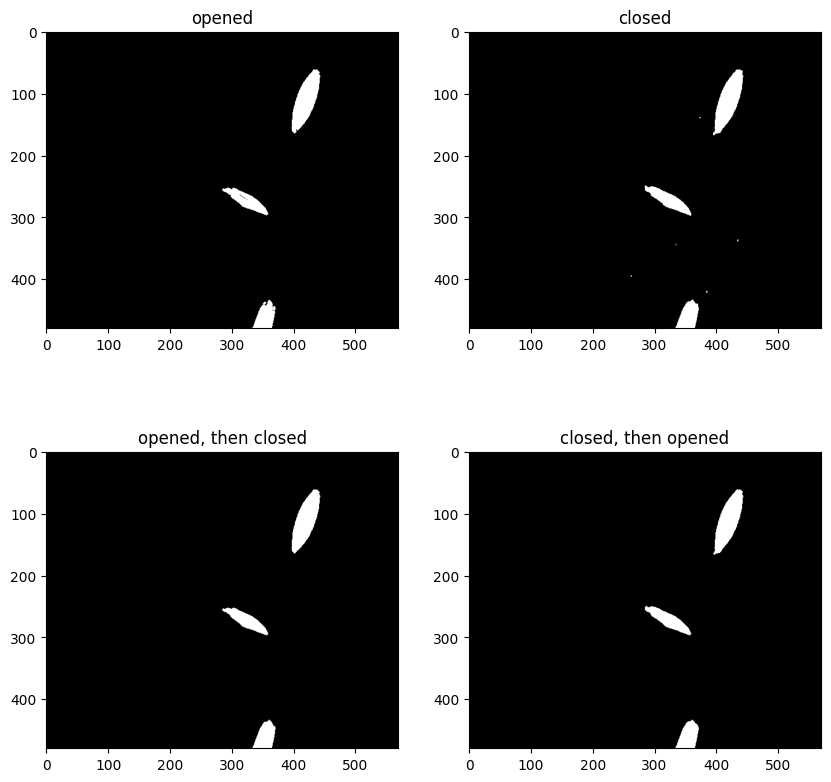

In [61]:
import numpy as np

# Try different morphological operations on the image

close_kernel = skimage.morphology.disk(3)
open_kernel = skimage.morphology.disk(2)

test_opened = skimage.morphology.opening(thresholded_frames[80], open_kernel)
test_closed = skimage.morphology.closing(thresholded_frames[80], close_kernel)
test_opened_closed = skimage.morphology.closing(test_opened, close_kernel)
test_closed_opened = skimage.morphology.opening(test_closed, open_kernel)

test_images = [test_opened, test_closed, test_opened_closed, test_closed_opened]
test_titles = ['opened', 'closed', 'opened, then closed', 'closed, then opened']

plt.figure(figsize=(10,10))
for i, (image, title) in enumerate(zip(test_images, test_titles)):
    plt.subplot(2,2,i+1)
    plt.imshow(image, 'gray',vmin=0,vmax=1)
    plt.title(title)

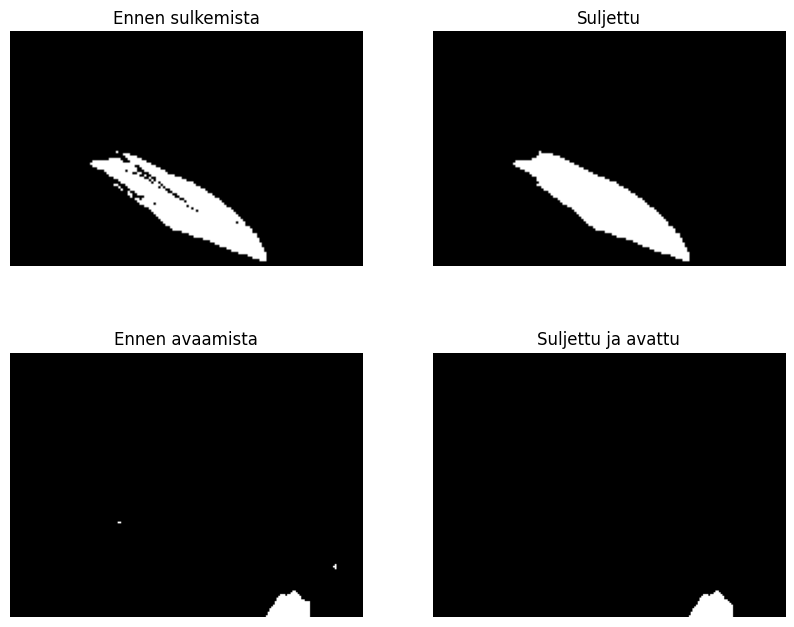

In [57]:
test_images = [thresholded_frames[80][200:300,250:400], test_closed[200:300,250:400], test_closed[300:450,200:400], test_closed_opened[300:450,200:400]]
test_titles = ['Ennen sulkemista', 'Suljettu', 'Ennen avaamista', 'Suljettu ja avattu']

plt.figure(figsize=(10,8))
for i, (image, title) in enumerate(zip(test_images, test_titles)):
    plt.subplot(2,2,i+1)
    plt.imshow(image, 'gray',vmin=0,vmax=1)
    plt.title(title)
    plt.axis('off')

Closing and then opening the image seems to be quite useful. Let's try masking the image using it with some dilation.

c:\Users\Zakru\git\seed_demo\venv\lib\site-packages\skimage\color\colorlabel.py:128: UserWarning: Negative intensities in `image` are not supported
  rgb = _label2rgb_overlay(label, image, colors, alpha, bg_label,
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


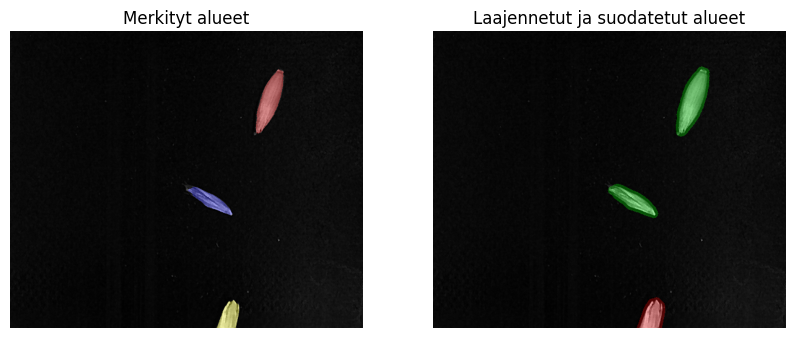

In [58]:
labels = skimage.measure.label(test_closed_opened, 0)

label_overlay = skimage.color.label2rgb(labels, grayscale_frames[80], bg_label=0)

expanded_labels = skimage.segmentation.expand_labels(labels, 5)

label_colors = []
for label in skimage.measure.regionprops(expanded_labels):
        top, left, bottom, right = label.bbox

        discard = top == 0 or left == 0 or bottom == grayscale_frames[80].shape[0] or right == grayscale_frames[80].shape[1]
        label_colors.append((1, 0, 0) if discard else (0, 1, 0))

label_overlay_discards = skimage.color.label2rgb(expanded_labels, grayscale_frames[80], label_colors, bg_label=0)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
for i, (img, title) in enumerate([(label_overlay, 'Merkityt alueet'), (label_overlay_discards, 'Laajennetut ja suodatetut alueet')]):
    ax[i].imshow(img)
    ax[i].set_title(title)
    ax[i].axis("off")

In [ ]:
params = cv2.SimpleBlobDetector_Params()

params.blobColor = 255

# Change thresholds
params.minThreshold = 10
params.maxThreshold = 255

# Filter by Area.
params.filterByArea = True
params.minArea = 25

# Filter by Circularity
params.filterByCircularity = False
# params.minCircularity = 0.1

# Filter by Convexity
params.filterByConvexity = False
# params.minConvexity = 0.87

# Filter by Inertia
params.filterByInertia = False
# params.minInertiaRatio = 0.01

blob_detector = cv2.SimpleBlobDetector_create(params)

# Detect blobs in the undilated mask
cv2.find
blobs = blob_detector.detectAndCompute(test_closed_opened)
blobs

error: OpenCV(4.9.0) :-1: error: (-5:Bad argument) in function 'detectAndCompute'
> Overload resolution failed:
>  - Feature2D.detectAndCompute() missing required argument 'mask' (pos 2)
>  - Feature2D.detectAndCompute() missing required argument 'mask' (pos 2)


In [ ]:
dilation_kernel = np.ones((20,20))

dilated = cv2.dilate(test_closed_opened, dilation_kernel)


fig, ax = plt.subplots(2,2, figsize=(15,15))
ax[0,0].imshow(cropped_frames[80])
ax[0,0].set_title('original')
ax[0,1].imshow(dilated, 'gray',vmin=0,vmax=255)
ax[0,1].set_title('dilated mask')
ax[1,0].imshow(cropped_frames[80] * np.repeat((test_closed_opened // 255)[...,None], 3, axis=2))
ax[1,0].set_title('masked using original mask')
ax[1,1].imshow(cropped_frames[80] * np.repeat((dilated // 255)[...,None], 3, axis=2))
ax[1,1].set_title('masked using dilated mask')

In [ ]:
params = cv2.SimpleBlobDetector_Params()

# Change thresholds
params.minThreshold = 10;
params.maxThreshold = 200;
 
# Filter by Area.
params.filterByArea = True
params.minArea = 25
 
# Filter by Circularity
params.filterByCircularity = False
# params.minCircularity = 0.1
 
# Filter by Convexity
params.filterByConvexity = False
# params.minConvexity = 0.87
 
# Filter by Inertia
params.filterByInertia = False
# params.minInertiaRatio = 0.01

blob_detector = cv2.SimpleBlobDetector_create(params)

# Detect blobs in the undilated mask
blobs = blob_detector.detect(test_closed_opened)
params.__dict__